## Importing Necessary Libraries

In [1]:
import pandas as pd # for dataframes
import numpy as np # for math
import matplotlib.pyplot as plt #for plotting 
import seaborn as sns #only for representation of correlation matrix

## Loading given csv files
I also noticed the use of null bhp in the power column instead of NA in some instances, i converted them to NaN values for convenient handling
I combined training and testing data so that any operation i perform to preprocess data applies to both in the same way
I also stored the number of training data so I can split it again later

In [2]:
train_data = pd.read_csv("Train.csv")
train_data = train_data.replace("null bhp", pd.NA).dropna()
train_features = train_data.shape[0]
test_data = pd.read_csv("Test.csv")
test_data = test_data.replace("null bhp", pd.NA).dropna()
total_data = pd.concat([train_data, test_data], axis=0)

## Data Pre-processing
Some of the data contained in the CSV, the Mileage, Power and Engine fields, had a unit affixed to it, making them work like classifications instead of numerical column. Using string replace and pd.to_numeric I converted it to numerical data
I then seperated the independent variables and dependant variable
I then split the dataframe to categorical, which I use one hot encoding for, and numerical, which I standardize.


In [3]:
data = total_data.drop([total_data.columns[0], 'Price'], axis=1)
data['Mileage'] = pd.to_numeric(data['Mileage'].str.replace(' kmpl', ''))
data['Power'] = pd.to_numeric(data['Power'].str.replace(' bhp', ''))
data['Engine'] = pd.to_numeric(data['Engine'].str.replace(' CC', ''))
y = total_data['Price']
data['Name'] = data['Name'].apply(lambda x: x.split()[0])
data_cat =data.select_dtypes(include=['object'])  
data_num = data.select_dtypes(include=['number'])
print(data_num)
mean = data_num.mean(axis=0)
std = data_num.std(axis=0)
data_num_norm = (data_num - mean) / std

data_cat_proc = pd.get_dummies(data_cat, drop_first=True) 
boolean_cols = data_cat_proc.columns[data_cat_proc.dtypes == 'bool']
data_cat_proc[boolean_cols] = data_cat_proc[boolean_cols].astype(int)

      Year  Kilometers_Driven  Mileage  Engine   Power  Seats
0     2017              16500    23.84    1199   84.00    5.0
1     2017              47357    18.49    1493  100.00    7.0
2     2014              35000    15.00    1598  103.52    5.0
3     2007             200000    17.20    1396   53.50    5.0
4     2013              64000    21.02    1248   88.76    5.0
...    ...                ...      ...     ...     ...    ...
1245  2013              71000    22.70    1582  126.20    5.0
1246  2005              91000    16.80    1341   83.00    5.0
1247  2017              50534    17.21    1197  103.50    5.0
1248  2012              83000    19.08    1582  126.32    5.0
1249  2019              13574    21.40    1197   83.10    5.0

[4873 rows x 6 columns]


### Getting rid of unnecessary data
An observation I took while I was experimenting with my model, is how a few features on removal had no effect/ even slightly improved model performance. But instead of just guesswork I needed a more concrete way to remove these specific features.
I came across correlation matrix and implemented it to remove useless features

<Axes: >

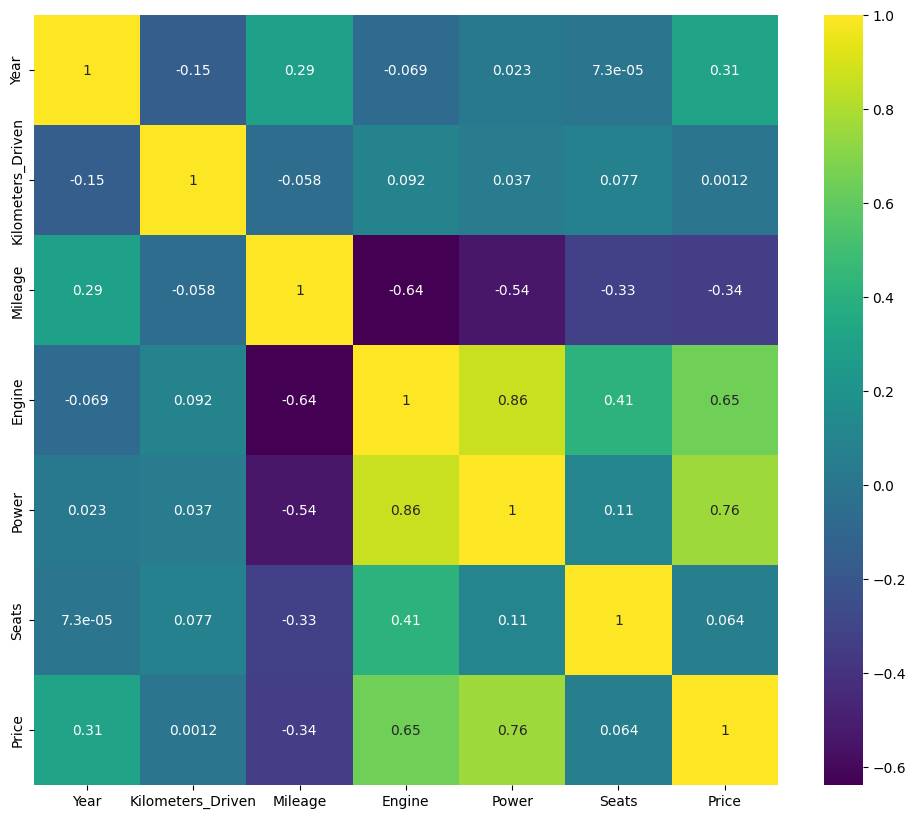

In [4]:
data_for_sns = pd.concat([data_num_norm, y], axis=1)
plt.figure(figsize=(12,10))
cor = data_for_sns.corr()
sns.heatmap(cor, annot=True, cmap = 'viridis')

In [5]:
def correlationfeattofeat(dataset, threshold = 0.9):
    column_cor = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                column_cor.add(colname)
    return column_cor
def correlationfeattotarget(dataset, threshold = 0.1):
    column_cor = set()
    corr_matrix = dataset.corr()
    for col in corr_matrix.columns:
        if abs(corr_matrix.loc['Price', col]) < threshold:
            column_cor.add(col)
    return column_cor

corr_features_irrelevant = correlationfeattotarget(data_for_sns)
print(corr_features_irrelevant)
corr_features_correlating = correlationfeattofeat(data_for_sns)
print(corr_features_correlating)
data_num_norm = data_num_norm.drop(corr_features_irrelevant, axis=1)
data_num_norm = data_num_norm.drop(corr_features_correlating, axis=1)
data_proc = pd.concat([data_num_norm, data_cat_proc], axis=1) 

{'Kilometers_Driven', 'Seats'}
set()


### Splitting dataset again
Now that the data preprocessing is complete, we will re-split training and testing data before performing linear regression

In [6]:
X_train = data_proc.iloc[:train_features]
X_test = data_proc.iloc[train_features:]
y_train = y.iloc[:train_features]
y_test = y.iloc[train_features:]
mse_values = []

## Performing Linear Regression
To perform linear regression, we create a linear regression class.

In [7]:
class LinearRegression:
    def __init__(self, lr = 0.7, n_iters = 100):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = 0
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        prev_mse = float('inf')
        for i in range(self.n_iters):
            y_predicted = np.dot(X, self.weights) + self.bias
            delw = (1/n_samples)*np.dot(X.T, (y_predicted - y))
            delb = (1/n_samples)*np.sum(y_predicted - y)
            self.weights = self.weights - self.lr*delw
            self.bias = self.bias - self.lr*delb
            mse = np.mean((y_predicted - y) ** 2)
            mse_values.append(mse)
        print(self.weights)
    def predict(self, X):
        y_predicted = np.dot(X, self.weights) + self.bias
        return y_predicted

### Creating object to perform Linear regression, plotting predicted prices vs actual test data

[ 3.30272818 -0.66981743  0.53738135  5.78532403  3.70773033  2.39228898
 -0.78967975 -0.23622557 -0.28399877 -0.04467621 -0.72232604 -2.50339758
 -1.44221539  0.         -0.07718829  2.76045142 -0.37222003  8.65275476
 -4.10524513  0.29863158  5.69382943  3.60697478  0.02556898 -0.83238706
  2.17285832 -1.19453767 -2.33112693 -1.05102215 -0.63037246 -1.85715348
 -0.31906641  2.37228543  1.37093454  2.34035757 -0.45652841  2.40025267
  1.10427461  0.72195981 -0.44595495 -0.27008498  0.66313578 -1.43558437
 -1.32432236 -0.01013875 -0.54150671  0.35177464]


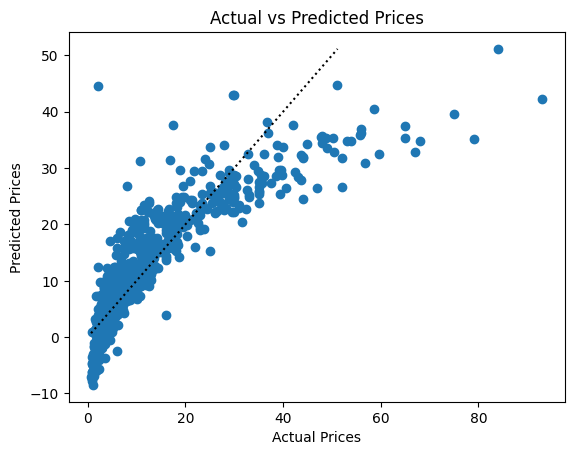

In [8]:
regressor = LinearRegression()
regressor.fit(X_train,y_train)
predictions = regressor.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.plot([min(y_test), max(predictions)], [min(y_test), max(predictions)], 'k:')
plt.show()

### Plotting change of MSE over iterations

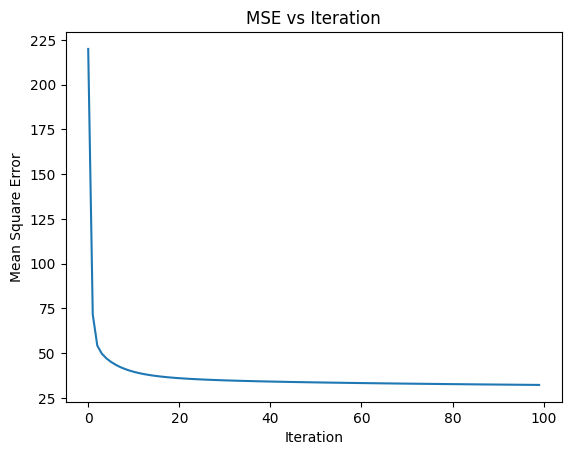

In [9]:
plt.plot(mse_values)
plt.xlabel('Iteration')
plt.ylabel('Mean Square Error')
plt.title('MSE vs Iteration')
plt.show()

### Computing R2 Score as a metric

In [10]:
total_sum = np.sum((y_test - np.mean(y_test)) ** 2)
residual_sum = np.sum((y_test - predictions) ** 2)
r2 = 1 - (residual_sum/total_sum)
print("R2 score of model:",r2)
print(mse_values[-1])

R2 score of model: 0.753045586789593
32.294685725765184
